##Modelo de detección de desinformación con Regresión Logística

Este notebook implementa un clasificador binario usando Regresión Logística para identificar contenido falso en textos. El flujo incluye: preprocesamiento (limpieza y vectorización con CountVectorizer), división 80/20 de los datos, y entrenamiento del modelo. La regresión logística fue elegida por su equilibrio entre rendimiento (97.99% de precisión) e interpretabilidad, superando alternativas como Random Forest. El análisis incluye métricas clave (precisión, recall, F1-score) y explicabilidad con SHAP.



##Librerías

In [ ]:
#Importación de librerías

import numpy as np
import pandas as pd
from pathlib import Path
from google.colab import drive

from sklearn.feature_extraction.text import CountVectorizer

# ML models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# scikit-learn:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pickle
from sklearn.metrics import roc_auc_score

from sklearn.metrics import make_scorer, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import make_scorer, f1_score

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek  # Combina SMOTE y Tomek Links


##DF

In [ ]:
#Montar drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Ruta del archivo
content_path = "/content/drive/MyDrive/Proyecto grado/Codigo/ML/Aleatorizacion-DataSetCompleto (1) (1).xlsx"

In [ ]:
#lee df
df_clasificado = pd.read_excel(content_path)
print(df_clasificado.sample(8))

      categoría            id            page_name  \
3635          4  1.410000e+15         Felipe Vélez   
638           3  9.875552e+14   Juan Carlos Upegui   
887           3  1.520000e+15         Felipe Vélez   
2671          4  8.695818e+14   Juan Carlos Upegui   
26            1  8.082605e+14  El Colombiano Parce   
2791          4  5.926202e+14   Juan Carlos Upegui   
3576          4  6.915592e+14         Felipe Vélez   
967           3  9.849003e+14         Felipe Vélez   

                                   transcripcion_pg_ext  \
3635  ['Muchos como yo y como vos que estás leyéndom...   
638   Yo soy Juan Carlos Upegui, si Dios quiere el p...   
887   Yo soy Felipe Vélez, estoy casado con Blanquit...   
2671            ['¡Vamos con toda! 💛✊🏼 #UpeguiAlcalde']   
26     Estudios recientes pronostican que para el 20...   
2791             ['#UpeguiAlcalde por los taxistas.💛🚕']   
3576  ['Increíble las denuncias del cartel de la con...   
967   Vamos a brillar. ¡Ay, mi vida! La s

In [ ]:
df_clasificado.shape

(3732, 18)

In [ ]:
df_clasificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3732 entries, 0 to 3731
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   categoría             3732 non-null   int64  
 1   id                    3732 non-null   float64
 2   page_name             3732 non-null   object 
 3   transcripcion_pg_ext  3732 non-null   object 
 4   trans_clean           3722 non-null   object 
 5   token_text            3732 non-null   object 
 6   Hate Speech           3732 non-null   int64  
 7   prob_emoción          3732 non-null   float64
 8   emocion               3732 non-null   object 
 9   prob_sentimiento      3732 non-null   float64
 10  Groserias             3732 non-null   int64  
 11  menciones_binaria     3732 non-null   int64  
 12  prob_sentimiento.1    3732 non-null   int64  
 13  prob_emoción.1        3732 non-null   int64  
 14  Hate Speech.1         3732 non-null   int64  
 15  Groserias.1          

In [ ]:
df_copy = df_clasificado.copy()

In [ ]:
##Eliminar columnas
df_copy.drop(columns=[
    'page_name',
    'transcripcion_pg_ext',
    'token_text',
    'Hate Speech',
    'prob_sentimiento',
    'emocion',
    'prob_emoción',
    'Groserias',
    'menciones_binaria',
    'prob_sentimiento.1',
    'prob_emoción.1',
    'Hate Speech.1',
    'Groserias.1',
    'menciones_binaria.1'
], inplace=True)

In [ ]:
df_copy

,categoría,id,trans_clean,Prob_Fake
0,1,2.253500e+14,medellin operado entramado corrupcion presunta...,0
1,1,8.440730e+14,medellin cartel contratacion denunciamos forma...,1
2,1,2.751852e+14,recuerda hablado cartel contratacion medellin ...,0
3,1,8.677843e+14,medellin cartel contratacion denunciamos forma...,1
4,1,1.732190e+15,medellin operado entramado corrupcion presunta...,0
...,...,...,...,...
3727,4,8.023435e+14,medellin necesita nuevos liderazgos necesitamo...,0
3728,4,7.224310e+14,29 octubre votamos carlosballesterosalcalde ad...,0
3729,4,8.447881e+14,porfinunamedellindetodxs cada vez vamos transf...,0
3730,4,1.050000e+15,medellin vision relacion actores publicos priv...,0


In [ ]:
df_copy.isnull().sum()

,0
categoría,0
id,0
trans_clean,10
Prob_Fake,0


In [ ]:
#Eliminar datos nulos
df_copy.dropna(inplace=True)

##Random Forest

In [ ]:
#Asignación variables
X = df_copy['trans_clean']
y = df_copy['Prob_Fake']

In [ ]:
# Dividir data de testeo y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)

In [ ]:
# Se importa y se instancia el vectorizador CountVectorizer (modelo Bag of Words)
vect = CountVectorizer()

# Se ajusta el vectorizador al texto de entrenamiento y se transforma en una matriz de términos
X_train_dtm = vect.fit_transform(X_train)

# Se transforma el texto de prueba utilizando el mismo vocabulario aprendido del entrenamiento
X_test_dtm = vect.transform(X_test)

# Se imprime la forma (número de documentos, número de palabras) de las matrices resultantes
print(X_train_dtm.shape, X_test_dtm.shape)


(2977, 7906) (745, 7906)


In [ ]:
# Importa el clasificador de Bosques Aleatorios
from sklearn.ensemble import RandomForestClassifier

# Crea una instancia del modelo Random Forest con una semilla fija para reproducibilidad
model_1 = RandomForestClassifier(random_state=42)

# Entrena el modelo usando la matriz de términos del conjunto de entrenamiento y sus etiquetas
# (en lugar de texto original, se usan las representaciones numéricas obtenidas con CountVectorizer)
model_1.fit(X_train_dtm, y_train)

# Realiza predicciones sobre el conjunto de prueba utilizando también su representación numérica
y_pred = model_1.predict(X_test_dtm)


In [ ]:
# Calcula la precisión del modelo comparando predicciones con las etiquetas reales
accuracy = accuracy_score(y_test, y_pred)

# Imprime la precisión en porcentaje con dos decimales
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 97.99%


In [ ]:
# Mostrar métricas de evaluación
print(classification_report(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       678
           1       0.98      0.79      0.88        67

    accuracy                           0.98       745
   macro avg       0.98      0.89      0.93       745
weighted avg       0.98      0.98      0.98       745

F1-Score: 0.8760330578512396


##Regresión logística



In [ ]:
#Importar librerías e instala
from sklearn.linear_model import LogisticRegression

In [ ]:
pip install shap

In [ ]:
import shap
import pandas as pd
import numpy as np
shap.initjs()
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Regresión logística
model_2 = LogisticRegression(random_state=42)

# Entrena el modelo usando la matriz de términos del conjunto de entrenamiento y sus etiquetas
model_2.fit(X_train_dtm, y_train)


LogisticRegression(random_state=42)

In [ ]:
# Genera las predicciones del modelo en el conjunto de prueba
y_pred_2 = model_2.predict(X_test_dtm)


In [ ]:
explainer = shap.Explainer(model_2, X_train_dtm)
shap_values = explainer(X_test_dtm)

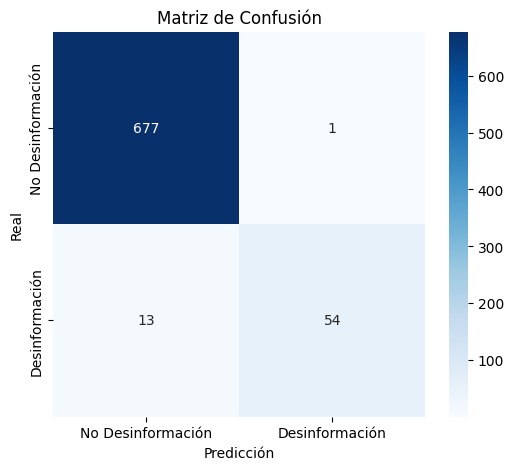

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred_2)

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Desinformación', 'Desinformación'], yticklabels=['No Desinformación', 'Desinformación'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.savefig("matriz_confusion.png", dpi=300, bbox_inches="tight")

plt.show()



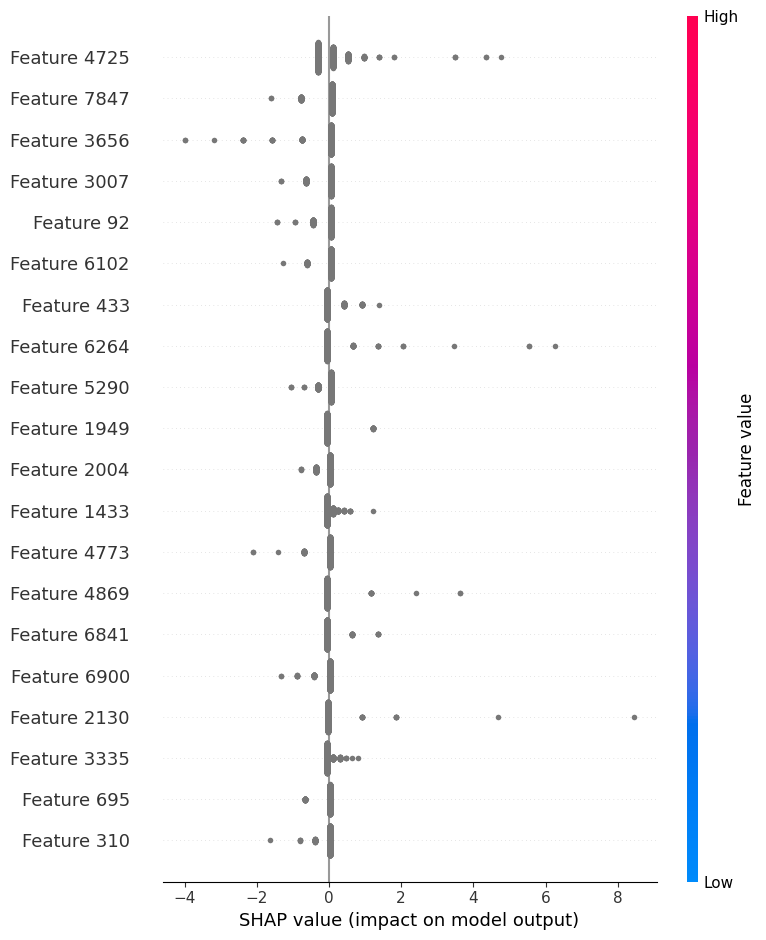

In [ ]:
# Muestra las palabras más influyentes en las predicciones, su frecuencia y su impacto (positivo o negativo) en la salida del modelo
shap.summary_plot(shap_values, X_test_dtm)

In [ ]:
# Obtener los nombres de las palabras
feature_names = vect.get_feature_names_out()

# Convertir las matrices sparse a DataFrames con nombres de columnas
X_train_df = pd.DataFrame(X_train_dtm.toarray(), columns=feature_names)
X_test_df = pd.DataFrame(X_test_dtm.toarray(), columns=feature_names)


In [ ]:
# Crear el explainer usando el modelo y el DataFrame de entrenamiento
explainer = shap.Explainer(model_2, X_train_df)

# Calcular valores SHAP sobre el set de prueba
shap_values = explainer(X_test_df)


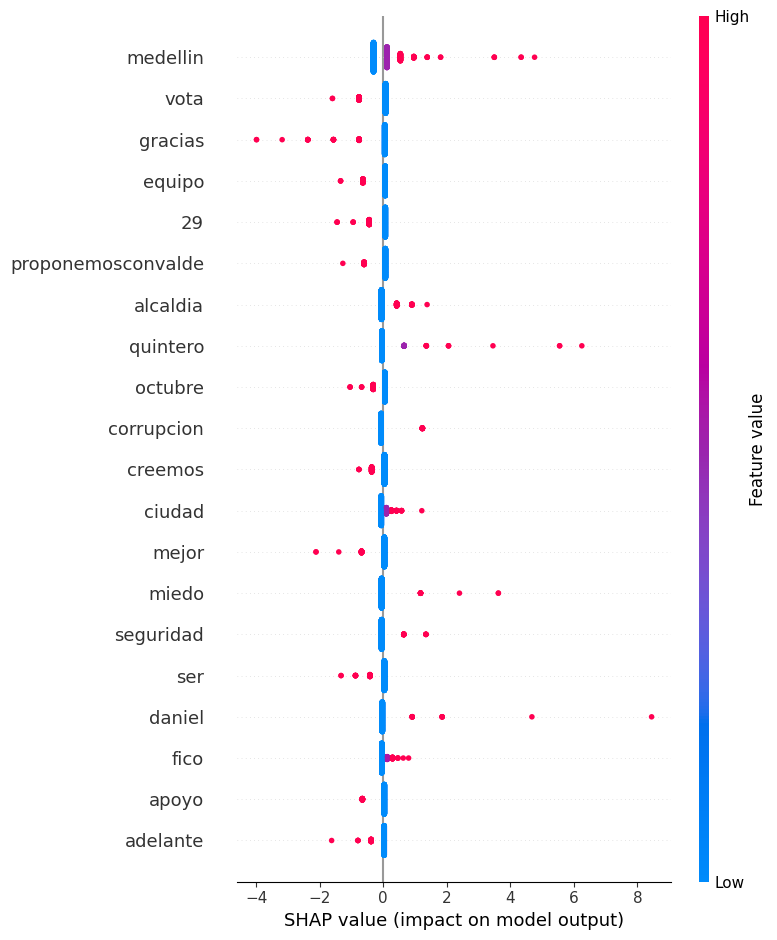

In [ ]:
shap.summary_plot(shap_values, X_test_df)


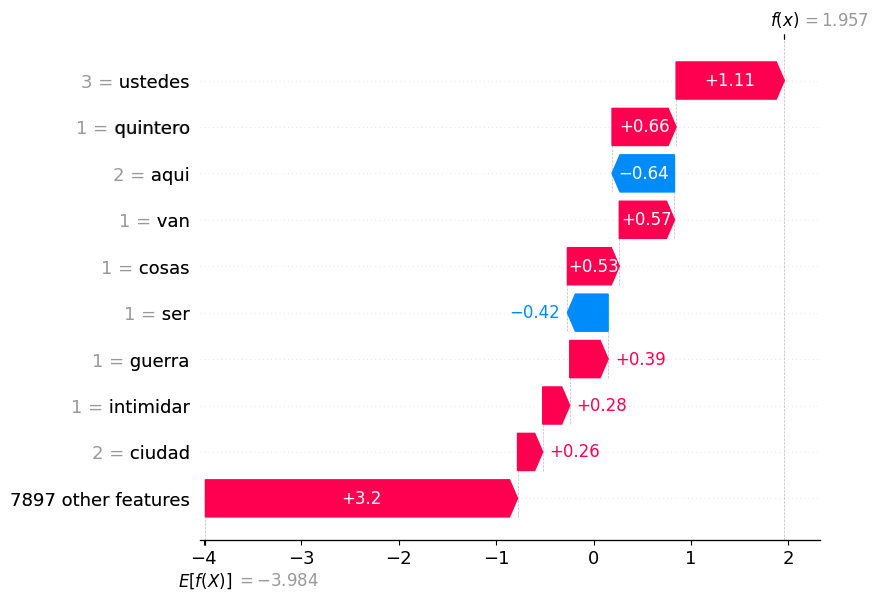

In [ ]:
# Por ejemplo, para el primer documento del test set
shap.plots.waterfall(shap_values[0])


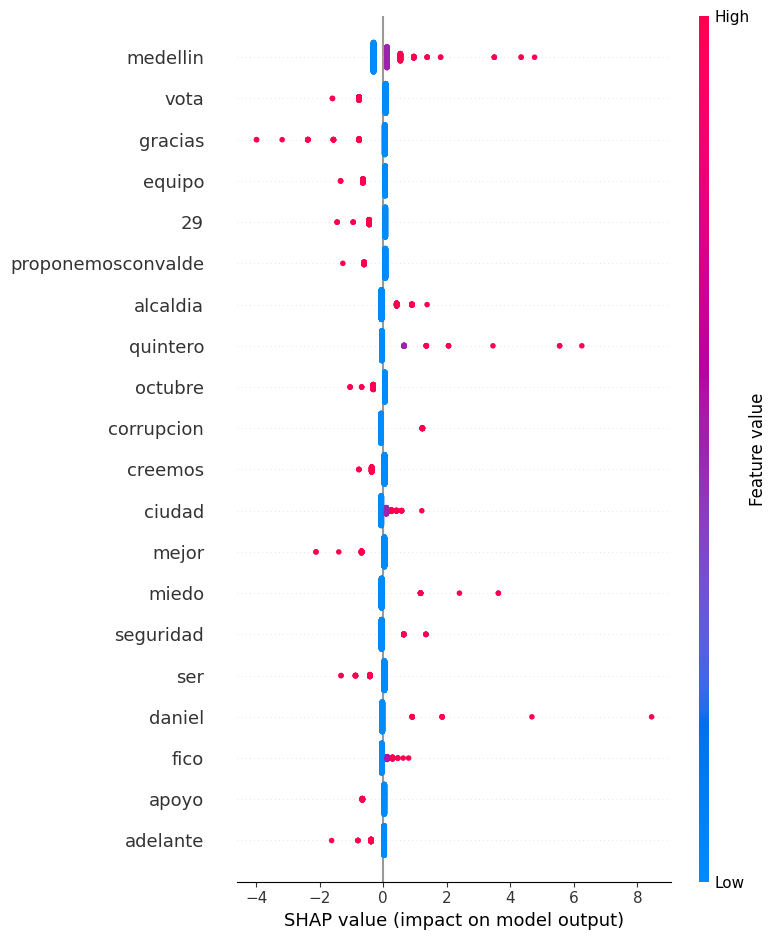

In [ ]:
shap.summary_plot(shap_values, X_test_df, show=True)


In [ ]:
# Extraer valores SHAP de la clase 1 (desinformación)
shap_values_class1 = shap_values[:, 1]  # Solo para clase 1

# Copiar los valores SHAP
shap_values_array = shap_values_class1.values.copy()

# Reemplazar valores negativos por 0
shap_values_array[shap_values_array < 0] = 0

# Reconstruir un objeto Explanation para clase 1 con solo valores positivos
shap_values_pos = shap.Explanation(
    values=shap_values_array,
    base_values=shap_values_class1.base_values,
    data=shap_values_class1.data,
    feature_names=shap_values_class1.feature_names
)

# Mostrar solo las features que empujan hacia "desinformación"
shap.summary_plot(shap_values_pos, X_test_df, max_display=50, show=True)



AssertionError: Summary plots need a matrix of shap_values, not a vector.

<Figure size 640x480 with 0 Axes>

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred_2))


In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred_2))


##GBOOST

In [ ]:
#Importar librerías
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
#Implementación modelo
model_3 = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_3.fit(X_train_dtm, y_train)


In [ ]:
# Genera las predicciones del modelo 3 en el conjunto de prueba (X_test_dtm)
y_pred_3 = model_3.predict(X_test_dtm)


In [1]:
#Métricas de evaluación
print("Accuracy:", accuracy_score(y_test, y_pred_3))
print("Classification Report:\n", classification_report(y_test, y_pred_3))


NameError: name 'accuracy_score' is not defined